# Importing libraries/modules

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning models and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model Interpretability
import shap
from lime import lime_tabular

# Save and load models
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Merging

In [2]:
# Load the datasets
calories_data = pd.read_csv('Calories.csv')
exercise_data = pd.read_csv('Exercise.csv')

# Display first few rows of the datasets
print("Calories Data:")
display(calories_data.head())

print("Exercise Data:")
display(exercise_data.head())

# Check the shape of the datasets
print("Calories Data shape:", calories_data.shape)
print("Exercise Data shape:", exercise_data.shape)

# Merge datasets on 'User_ID'
data = pd.merge(exercise_data, calories_data, on='User_ID')

# Display the first few rows of the merged data
print("Merged Data:")
display(data.head())

# Drop 'User_ID' as it is not needed for modeling
data.drop('User_ID', axis=1, inplace=True)

Calories Data:


,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


Exercise Data:


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


Calories Data shape: (15000, 2)
Exercise Data shape: (15000, 8)
Merged Data:


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


# Data Exploration and Preprocessing

## Checking for Missing Values and Data Types

In [3]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Check data types
print("\nData types of each column:")
print(data.dtypes)

Missing values in each column:
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Data types of each column:
Gender         object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object


## Exploratory Data Analysis (EDA)

### Statistical Summary

In [4]:
# Statistical summary of the dataset
data.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


### Distribution of Numerical Variables

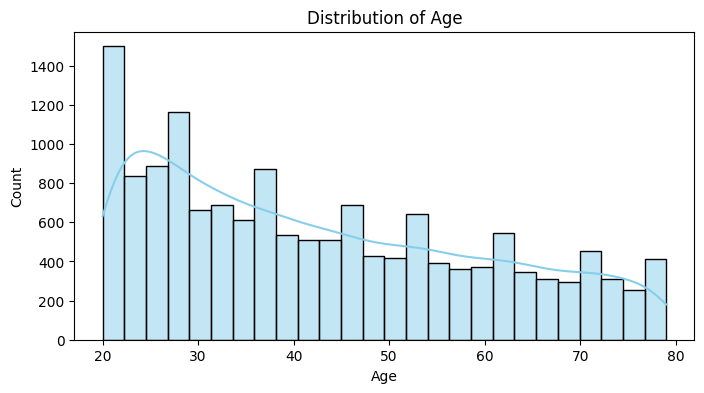

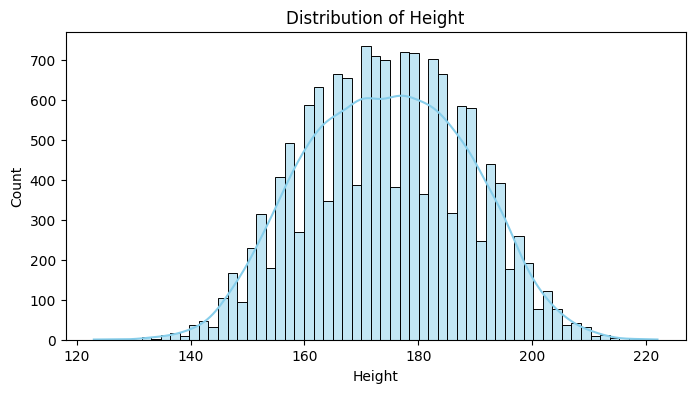

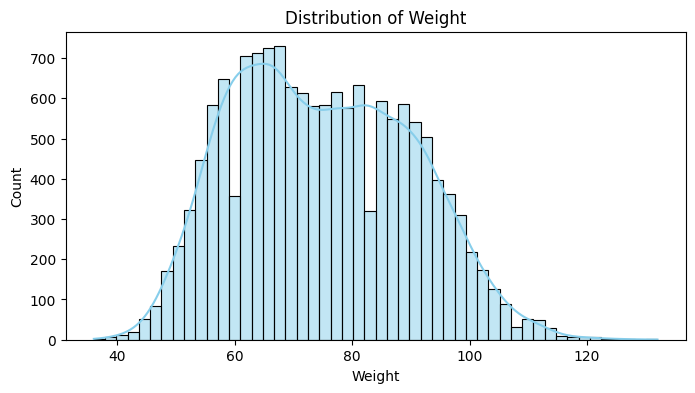

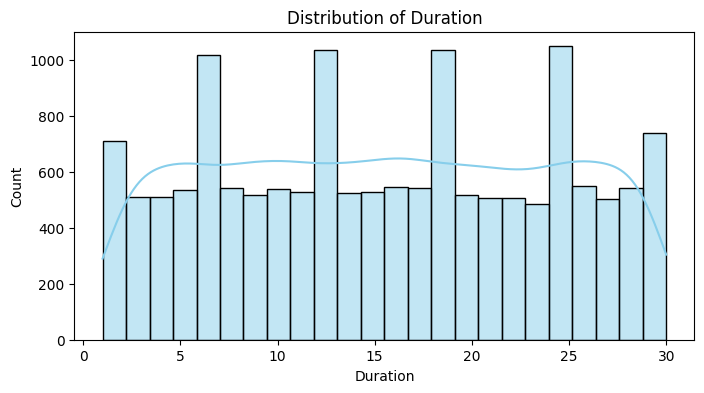

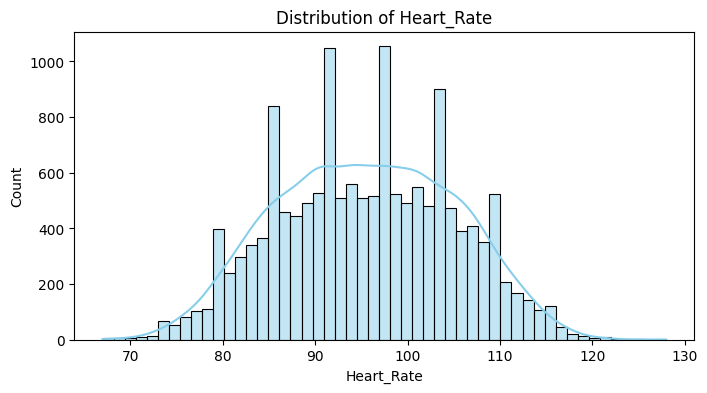

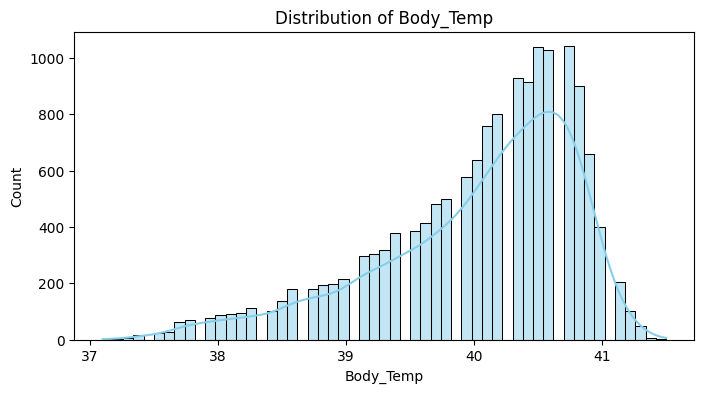

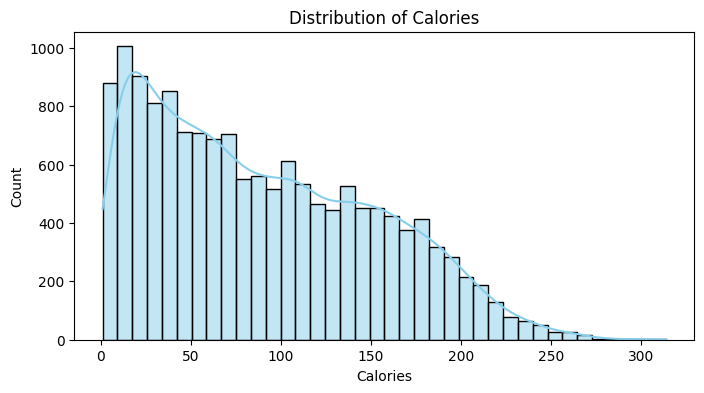

In [5]:
# List of numerical features
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Plot distributions
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.show()

### Categorical Variable Analysis

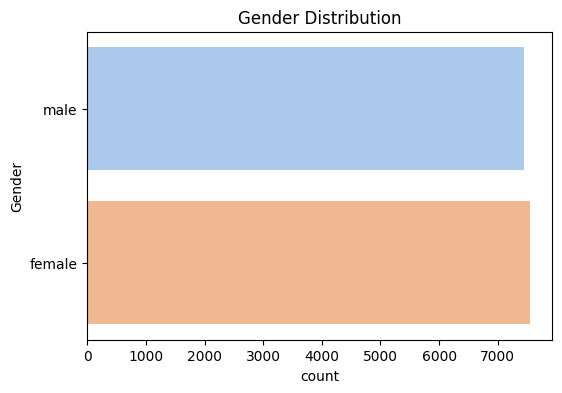

In [6]:
# Count plot for 'Gender'
plt.figure(figsize=(6, 4))
sns.countplot(data['Gender'], palette='pastel')
plt.title('Gender Distribution')
plt.show()

### Correlation Matrix

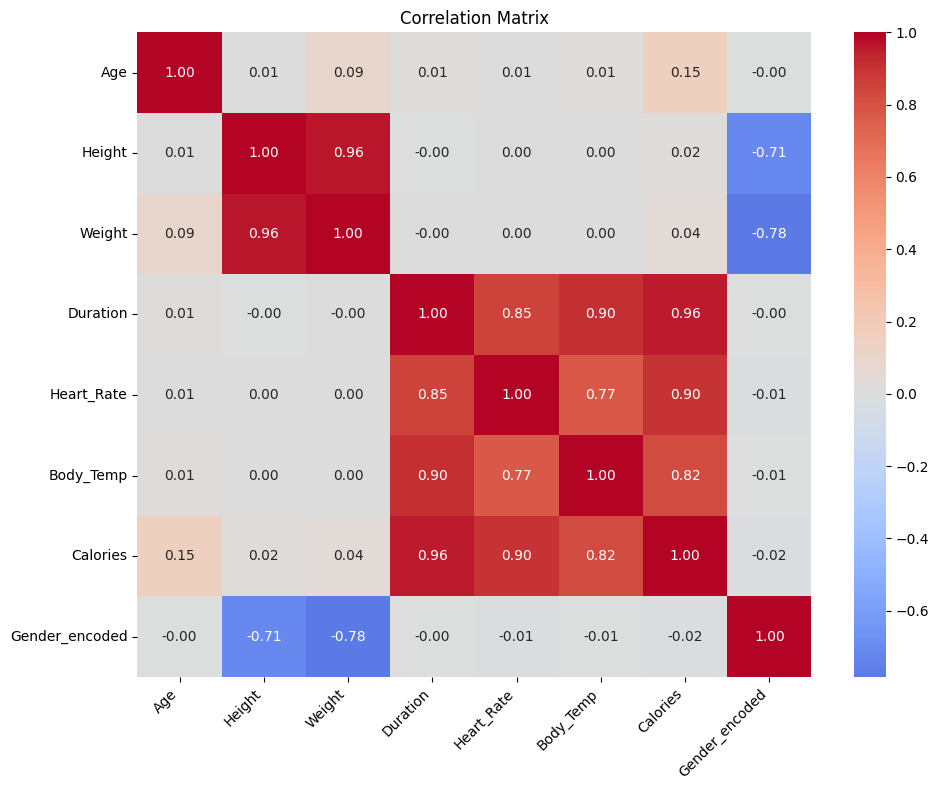

In [7]:
# First encode the gender column
data['Gender_encoded'] = data['Gender'].map({'male': 0, 'female': 1})

# Get only numeric columns for correlation
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
correlation_data = data[numeric_columns]

# Calculate correlation matrix
corr = correlation_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Insights:
Strong Positive Correlation: 'Duration', 'Heart_Rate', and 'Body_Temp' have strong positive correlations with 'Calories'.
Feature Importance: These features are likely to be significant predictors in our model.

# Feature Engineering and Preprocessing

## Creating New Features

In [8]:
# Body Mass Index (BMI)
data['BMI'] = data['Weight'] / (data['Height']/100)**2

# Age Groups
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])

# Interaction Features
data['Duration_HeartRate'] = data['Duration'] * data['Heart_Rate']

## Encoding Categorical Variables

In [9]:
# One-Hot Encoding for 'Gender' and 'Age_Group'
data = pd.get_dummies(data, columns=['Gender', 'Age_Group'], drop_first=True)

# Drop 'Gender_encoded' to prevent redundancy
data.drop('Gender_encoded', axis=1, inplace=True)

# Display the updated dataframe
display(data.head())

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Duration_HeartRate,Gender_male,Age_Group_Middle-aged,Age_Group_Senior
0,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3045.0,True,False,True
1,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,1316.0,False,False,False
2,69,179.0,79.0,5.0,88.0,38.7,26.0,24.655910,440.0,True,False,True
3,34,179.0,71.0,13.0,100.0,40.5,71.0,22.159109,1300.0,False,True,False
4,27,154.0,58.0,10.0,81.0,39.8,35.0,24.456063,810.0,False,False,False


## Feature Selection

In [10]:
# Define feature matrix X and target vector y
X = data.drop('Calories', axis=1)
y = data['Calories']

print("Features used for modeling:")
print(X.columns.tolist())

Features used for modeling:
['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Duration_HeartRate', 'Gender_male', 'Age_Group_Middle-aged', 'Age_Group_Senior']


## Data Scaling

In [11]:
# Define numerical features (excluding 'Calories')
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Duration_HeartRate']

# Scaling numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Save the scaler for later use in prediction
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Train-Test Split

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['Age_Group_Senior'], random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (12000, 11)
Testing set shape: (3000, 11)


# Model Training and Evaluation

## Cross-Validation Strategy

In [13]:
# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Linear Regression

In [14]:
# Initialize model
lr_model = LinearRegression()

# Cross-validation scores
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
mean_cv_score = -np.mean(cv_scores)

print(f"Linear Regression Cross-Validated MAE: {mean_cv_score:.6f}")

# Fit the model
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Test MAE: {mae_lr:.6f}")
print(f"Linear Regression Test R^2 Score: {r2_lr:.6f}")

Linear Regression Cross-Validated MAE: 5.794868
Linear Regression Test MAE: 5.721257
Linear Regression Test R^2 Score: 0.984693


## Random Forest Regression

In [15]:
# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
mean_cv_score = -np.mean(cv_scores)

print(f"\nRandom Forest Cross-Validated MAE: {mean_cv_score:.6f}")

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test MAE: {mae_rf:.6f}")
print(f"Random Forest Test R^2 Score: {r2_rf:.6f}")


Random Forest Cross-Validated MAE: 1.861066
Random Forest Test MAE: 1.710587
Random Forest Test R^2 Score: 0.998169


## XGBoost Regression

In [16]:
# Initialize model
xgb_model = XGBRegressor(random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
mean_cv_score = -np.mean(cv_scores)

print(f"\nXGBoost Cross-Validated MAE: {mean_cv_score:.6f}")

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test MAE: {mae_xgb:.6f}")
print(f"XGBoost Test R^2 Score: {r2_xgb:.6f}")


XGBoost Cross-Validated MAE: 1.438262
XGBoost Test MAE: 1.362980
XGBoost Test R^2 Score: 0.999057


## Deep Learning Model (Neural Network)

### Building the Model

In [17]:
# Define the model architecture
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    return model

# Create the model
nn_model = create_model()

### Compiling and Training the Model

In [18]:
# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

### Plotting Training History

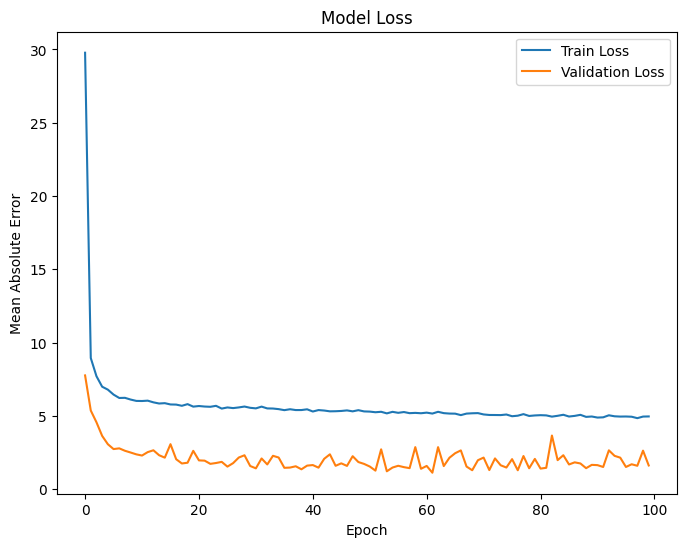

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Evaluating the Model

In [20]:
# Predict on test data
y_pred_nn_optimized = nn_model.predict(X_test).flatten()

# Evaluate the optimized model
mae_nn = mean_absolute_error(y_test, y_pred_nn_optimized)
r2_nn = r2_score(y_test, y_pred_nn_optimized)

print(f"\nOptimized Neural Network Test MAE: {mae_nn:.6f}")
print(f"Optimized Neural Network Test R^2 Score: {r2_nn:.6f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step

Optimized Neural Network Test MAE: 1.629157
Optimized Neural Network Test R^2 Score: 0.998864


# Hyperparameter Tuning

## Random Forest Hyperparameter Tuning

In [21]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 15, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the grid search
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Predict on test data with best estimator
y_pred_rf_best = grid_search_rf.best_estimator_.predict(X_test)

# Evaluate the model
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print(f"\nRandom Forest Tuned Test MAE: {mae_rf_best:.6f}")
print(f"Random Forest Tuned Test R^2 Score: {r2_rf_best:.6f}")

Best parameters for Random Forest:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Tuned Test MAE: 1.687683
Random Forest Tuned Test R^2 Score: 0.998187


## XGBoost Hyperparameter Tuning

In [22]:
# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize model
xgb = XGBRegressor(random_state=42)

# GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:")
print(grid_search_xgb.best_params_)

# Predict on test data with best estimator
y_pred_xgb_best = grid_search_xgb.best_estimator_.predict(X_test)

# Evaluate the model
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

print(f"\nXGBoost Tuned Test MAE: {mae_xgb_best:.6f}")
print(f"XGBoost Tuned Test R^2 Score: {r2_xgb_best:.6f}")

Best parameters for XGBoost:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

XGBoost Tuned Test MAE: 1.135088
XGBoost Tuned Test R^2 Score: 0.999368


# Model Comparison

In [23]:
# Summarize model performance
model_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Random Forest Tuned', 'XGBoost', 'XGBoost Tuned', 'Neural Network'],
    'MAE': [mae_lr, mae_rf, mae_rf_best, mae_xgb, mae_xgb_best, mae_nn],
    'R^2 Score': [r2_lr, r2_rf, r2_rf_best, r2_xgb, r2_xgb_best, r2_nn]
})

display(model_results.sort_values(by='MAE'))

,Model,MAE,R^2 Score
4,XGBoost Tuned,1.135088,0.999368
3,XGBoost,1.362980,0.999057
5,Neural Network,1.629157,0.998864
2,Random Forest Tuned,1.687683,0.998187
1,Random Forest,1.710587,0.998169
0,Linear Regression,5.721257,0.984693


#### Insights:

XGBoost Tuned Model has the lowest MAE and the highest R² score, indicating better performance.

# Model Interpretability with SHAP

## Applying SHAP to the XGBoost Model

In [24]:
# Initialize the SHAP explainer
explainer = shap.Explainer(grid_search_xgb.best_estimator_)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

## Visualizing Feature Importance

### SHAP Summary Plot

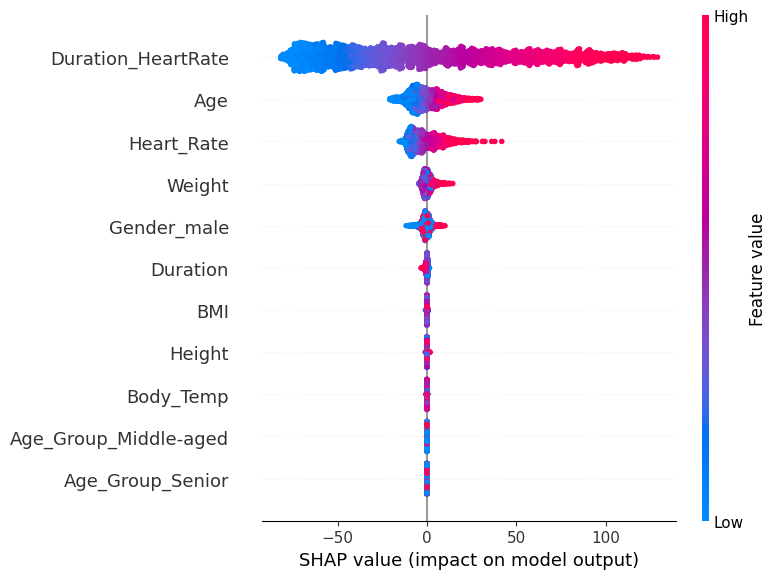

In [25]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test)

### SHAP Dependence Plots

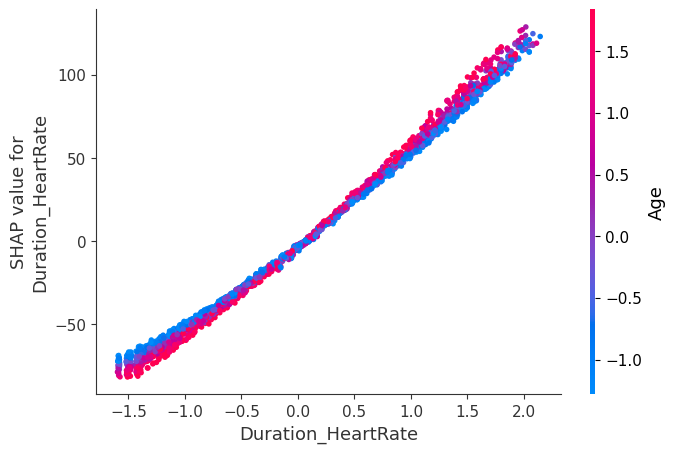

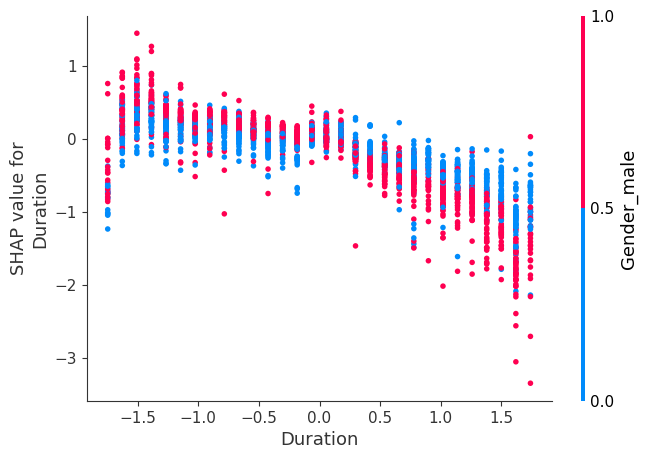

In [26]:
# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(grid_search_xgb.best_estimator_)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)  # For older versions
# For newer versions, use:
# shap_values = explainer(X_test)

# If shap_values is an Explanation object, extract the values
if isinstance(shap_values, shap.Explanation):
    shap_values_array = shap_values.values
else:
    shap_values_array = shap_values

# SHAP dependence plot for 'Duration_HeartRate'
shap.dependence_plot('Duration_HeartRate', shap_values_array, X_test)

# SHAP dependence plot for 'Duration'
shap.dependence_plot('Duration', shap_values_array, X_test)

## SHAP Force Plot for a Single Prediction

In [27]:
# Select a single instance as a DataFrame
instance = X_test.iloc[[0]].copy()
instance.reset_index(drop=True, inplace=True)

# Check data types
print(instance.dtypes)

Age                      float64
Height                   float64
Weight                   float64
Duration                 float64
Heart_Rate               float64
Body_Temp                float64
BMI                      float64
Duration_HeartRate       float64
Gender_male                 bool
Age_Group_Middle-aged       bool
Age_Group_Senior            bool
dtype: object


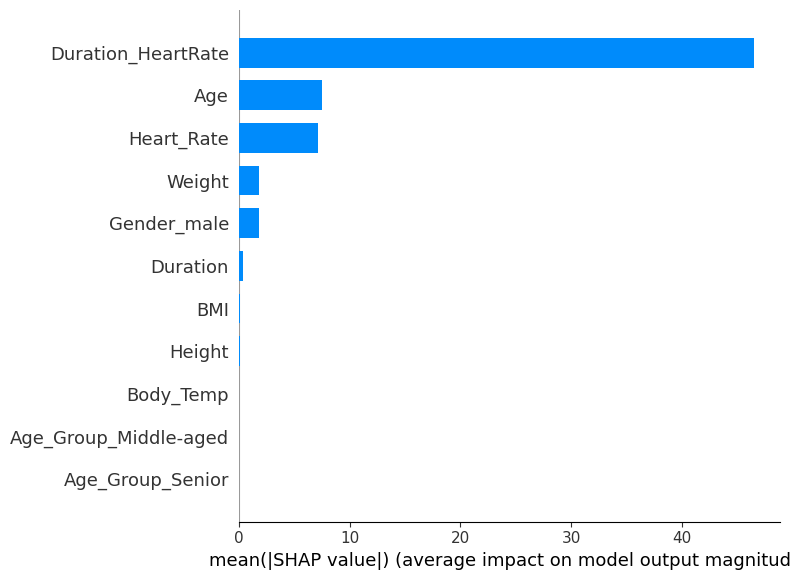

In [28]:
# SHAP bar plot to show mean absolute value of the SHAP values for each feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Checking for Overfitting

In [29]:
# Evaluate the best XGBoost model on training data
y_train_pred_xgb_best = grid_search_xgb.best_estimator_.predict(X_train)

# Training performance
mae_xgb_train = mean_absolute_error(y_train, y_train_pred_xgb_best)
r2_xgb_train = r2_score(y_train, y_train_pred_xgb_best)

print("XGBoost Tuned Training Performance:")
print(f"Training MAE: {mae_xgb_train:.6f}")
print(f"Training R^2 Score: {r2_xgb_train:.6f}")

XGBoost Tuned Training Performance:
Training MAE: 0.896902
Training R^2 Score: 0.999632


#### Analysis:

Similar Training and Testing MAE: Indicates that the model is not overfitting and generalizes well to unseen data.
High R² Score on Training Data: Shows the model fits the training data well.

# Saving the Model

In [30]:
# Save the best model
joblib.dump(grid_search_xgb.best_estimator_, 'calories_burned_xgb_model.pkl')
print("Model saved successfully.")

Model saved successfully.


# Making Predictions with New Data

In [31]:
def predict_calories(input_data):
    """
    Predicts the number of calories burned given input data.
    
    Parameters:
    input_data (dict): Dictionary containing input data with keys:
        - Gender (str): 'male' or 'female'
        - Age (float)
        - Height (float)
        - Weight (float)
        - Duration (float)
        - Heart_Rate (float)
        - Body_Temp (float)
    
    Returns:
    float: Predicted calories burned.
    """
    # Create DataFrame from input data
    input_df = pd.DataFrame([input_data])

    # Feature Engineering
    input_df['BMI'] = input_df['Weight'] / (input_df['Height']/100)**2
    input_df['Duration_HeartRate'] = input_df['Duration'] * input_df['Heart_Rate']
    input_df['Age_Group'] = pd.cut(input_df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])

    # One-Hot Encoding
    input_df = pd.get_dummies(input_df, columns=['Gender', 'Age_Group'], drop_first=True)

    # Ensure all features are present in the same order as training data
    missing_cols = set(X.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0
    input_df = input_df[X.columns]

    # Load the scaler
    scaler = joblib.load('scaler.pkl')

    # Define numerical features (excluding 'Calories')
    numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Duration_HeartRate']

    # Scale numerical features
    input_df[numerical_features] = scaler.transform(input_df[numerical_features])

    # Load the saved model
    model = joblib.load('calories_burned_xgb_model.pkl')

    # Predict
    predicted_calories = model.predict(input_df)

    return predicted_calories[0]


# Sample input data
sample_input = {
    'Gender': 'male',
    'Age': 28,
    'Height': 170,
    'Weight': 75,
    'Duration': 30,
    'Heart_Rate': 120,
    'Body_Temp': 38.5
}

# Predict and explain
predicted_calories = predict_calories(sample_input)

print(f"Predicted Calories Burned: {predicted_calories:.2f}")

Predicted Calories Burned: 224.70
